<a href="https://colab.research.google.com/github/singhn156/Time_Series/blob/main/Time_Series_Forecasting_for_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem:

For this particular assignment, the data of different types of wine sales in the 20th century is to be analysed. Both of these data are from the same company but of different wines. As an analyst in the ABC Estate Wines, you are tasked to analyse and forecast Wine Sales in the 20th century.

Data set for the Problem: Sparkling.csv and Rose.csv

Please do perform the following questions on each of these two data sets separately.

1. Read the data as an appropriate Time Series data and plot the data.
2. Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.
3. Split the data into training and test. The test data should start in 1991.
4. Build various exponential smoothing models on the training data and evaluate the model using RMSE on the test data.
5. Other models such as regression,naïve forecast models, simple average models etc. should also be built on the training data and check the performance on the test data using RMSE.
6. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment.

Note: Stationarity should be checked at alpha = 0.05.

7. Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.
8. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.
9. Build a table with all the models built along with their corresponding parameters and the respective RMSE values on the test data.
10. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.


Comment on the model thus built and report your findings and suggest the measures that the company should be taking for future sales.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error 
from math import sqrt 
import statsmodels.api as sms
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import kpss

In [ ]:
rose = pd.read_csv("/content/drive/MyDrive/Upwork/Rose.csv")

### **1. Sample of the dataset:**

In [ ]:
rose.head()

,YearMonth,Rose
0,1980-01,112.0
1,1980-02,118.0
2,1980-03,129.0
3,1980-04,99.0
4,1980-05,116.0


## **2. Exploratory Data Analysis**

Missing value imputation using bfill method : bfill() is used to backward fill the missing values in the dataset. It will backward fill the NaN values that are present in the pandas dataframe.

In [ ]:
rose.isnull().sum()

YearMonth    0
Rose         2
dtype: int64

In [ ]:
rose = rose.fillna(method ='bfill')

Let us check the types of variables in the data frame.

In [ ]:
rose.shape

(187, 2)

In [ ]:
rose.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YearMonth  187 non-null    object 
 1   Rose       187 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


Date columns in dataset has to be in correct pd.datatime format

In [ ]:
rose["YearMonth"] = pd.to_datetime(rose["YearMonth"])


Vislualisation of Rose wine sales for year 1980 to 1995

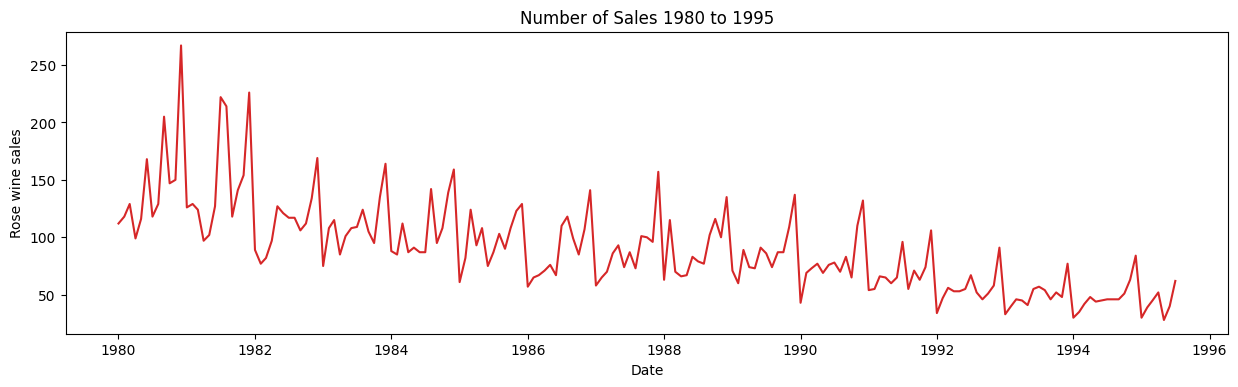

In [ ]:

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Rose wine sales', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(rose, x=rose['YearMonth'], y=rose['Rose'], title='Number of Sales 1980 to 1995')

Creating new columns for understanding of dataset.

In [ ]:
rose["year"] = rose["YearMonth"].dt.year
rose["month"] = rose["YearMonth"].dt.month

Sales is showing downward trend as years increase

Text(0.5, 1.0, 'Frequency for Wine sale and respective years')

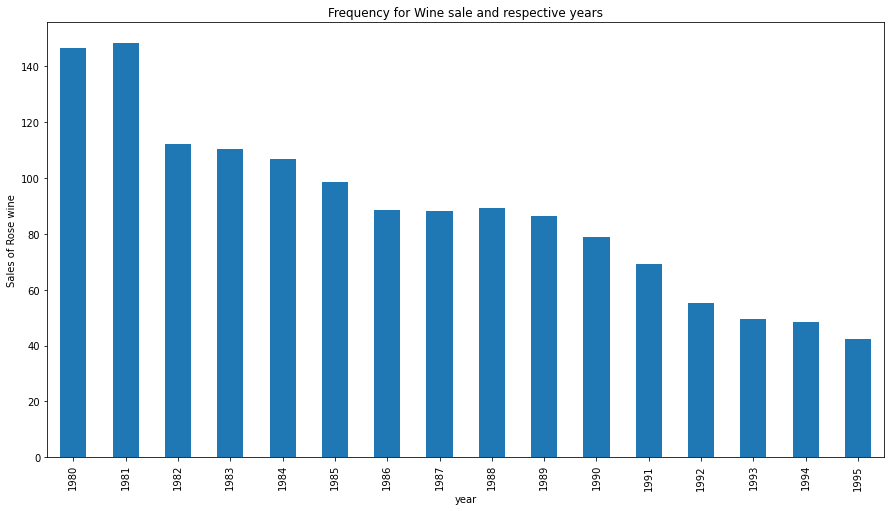

In [ ]:
plt.rcParams['figure.figsize'] = (15,8)
rose.groupby('year')['Rose'].mean().plot.bar()
plt.ylabel("Sales of Rose wine")
plt.title("Frequency for Wine sale and respective years")

December and November showing higher sales while January and feburary dip lower on chart.


Text(0.5, 1.0, 'Frequency for Wine sale and respective months')

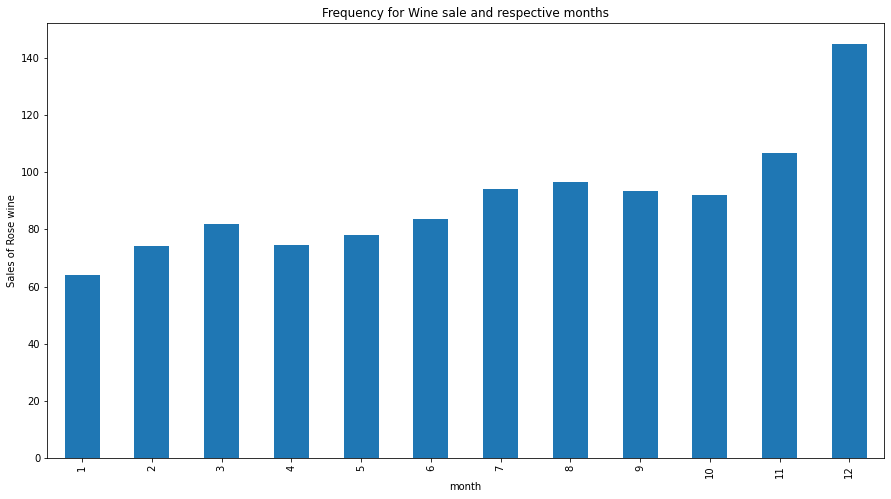

In [ ]:
plt.rcParams['figure.figsize'] = (15,8)
rose.groupby('month')['Rose'].mean().plot.bar()
plt.ylabel("Sales of Rose wine")
plt.title("Frequency for Wine sale and respective months")

### **3. Decomposition of Series**

We can decompose the time series in four parts.

Observed, which is the original time series. Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series. Seasonal, which tells us about the seasonality in the time series. Residual, which is obtained by removing any trend or seasonality in the time series.

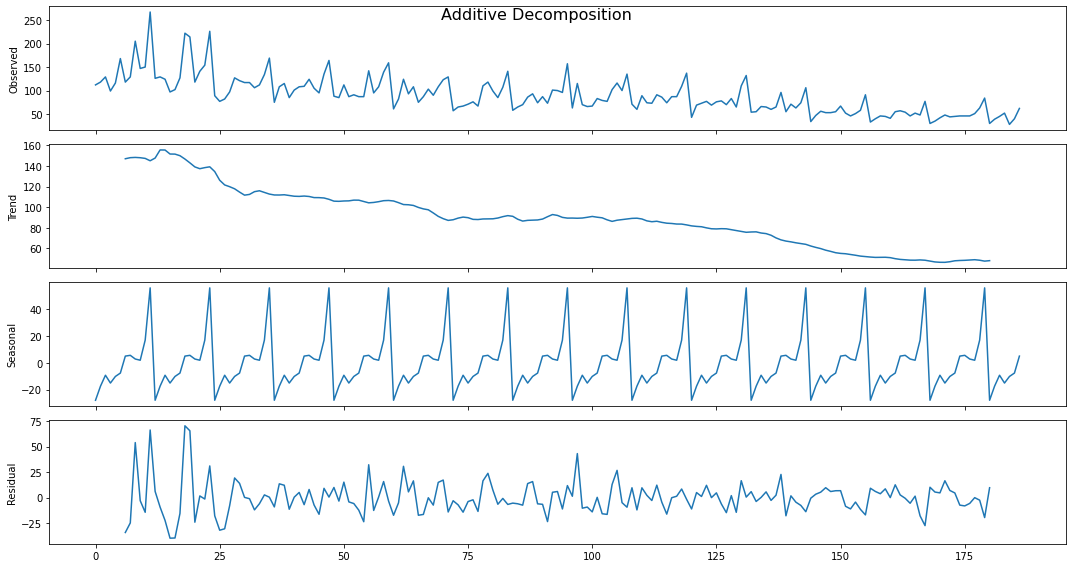

In [ ]:
plt.rcParams['figure.figsize'] = (15,8)
decom = sms.tsa.seasonal_decompose(rose["Rose"],model = "additive",freq = 12)
fig = decom.plot().suptitle('Additive Decomposition', fontsize=16)
plt.show()

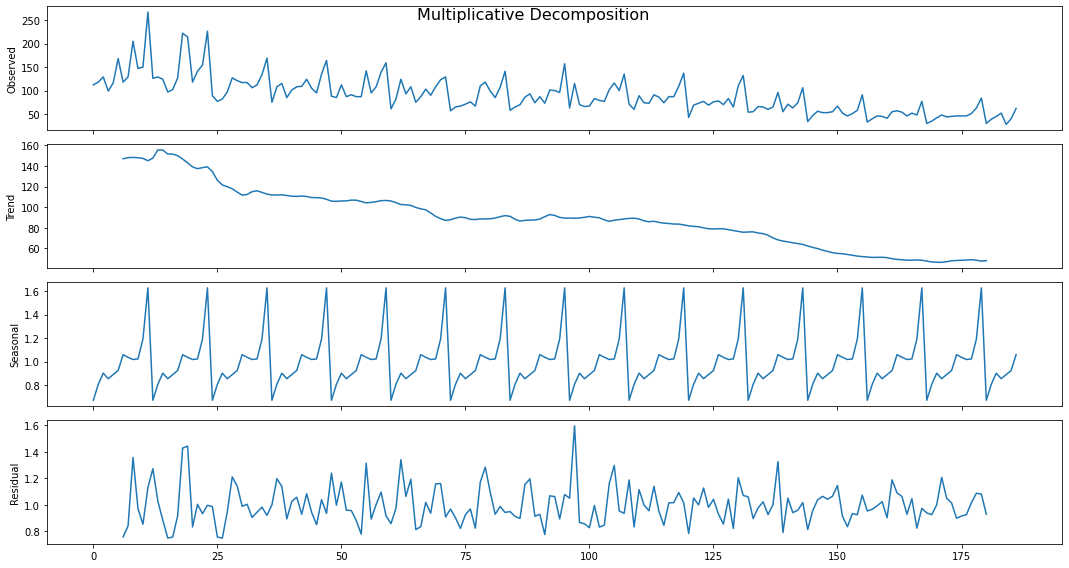

In [ ]:
plt.rcParams['figure.figsize'] = (15,8)
decom = sms.tsa.seasonal_decompose(rose["Rose"],model = "multiplicative",freq = 12)

fig = decom.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.show()

### **4. Data Preparation before modelling**

Splitting dateset into Train and valid set 

In [ ]:
rose = rose.set_index('YearMonth')

In [ ]:

Train=rose.loc['1980-01-01':'1990-12-01'] 
valid=rose.loc['1991-01-01':]

In [ ]:
Train.shape

(132, 3)

In [ ]:
valid.shape

(55, 3)

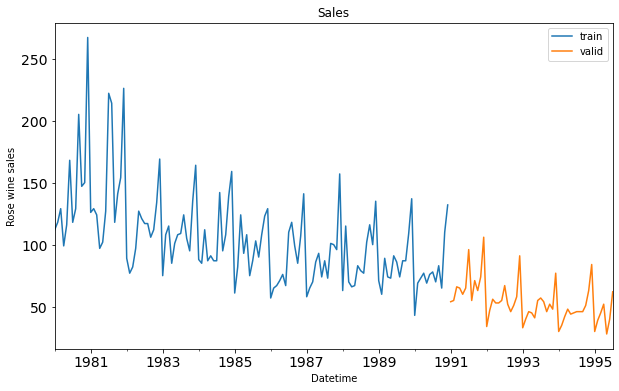

In [ ]:
Train.Rose.plot(figsize=(10,6), title= 'Sales', fontsize=14, label='train') 
valid.Rose.plot(figsize=(10,6), title= 'Sales', fontsize=14, label='valid') 
plt.xlabel("Datetime") 
plt.ylabel("Rose wine sales") 
plt.legend(loc='best') 
plt.show()

### **5. Basic Models and  Methodology**

We will look at various models now to forecast the time series . Methods which we will be discussing for the forecasting are:

i) Naive Approach ii) Moving Average iii) Simple Exponential Smoothing iv) Holt’s Linear Trend Model







**5.1 Naive Approach**

In this forecasting technique, the value of the new data point is predicted to be equal to the previous data point. The result would be a flat line, since all new values take the previous values.

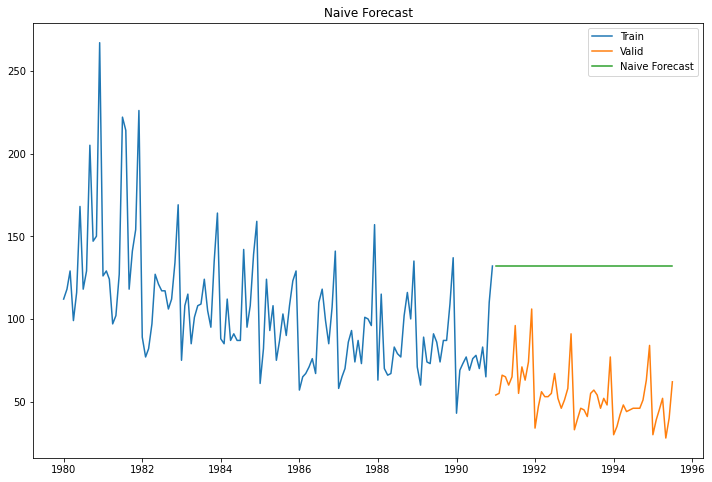

In [ ]:
#Naive Approach
dd= np.asarray(Train.Rose)
y_hat = valid.copy() 
y_hat['naive'] = dd[len(dd)-1] 
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train['Rose'], label='Train') 
plt.plot(valid.index,valid['Rose'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()

In [ ]:

rms_naive = sqrt(mean_squared_error(valid.Rose, y_hat.naive)) 
print(rms_naive)

79.69909318521418


**5.2 Moving Average**

This is an improvement over the previous technique. Instead of taking the average of all the previous points, the average of ‘n’ previous points is taken to be the predicted value.


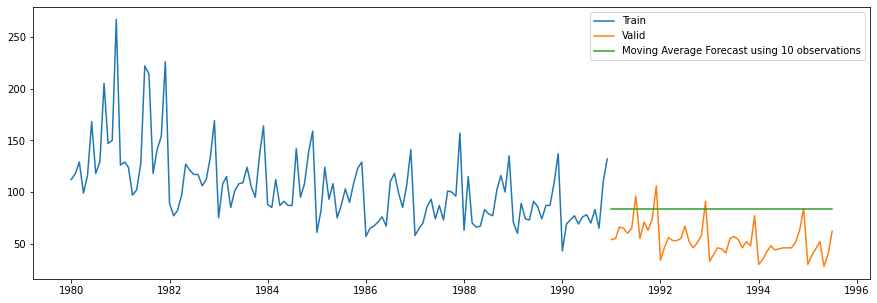

In [ ]:
#Moving Average
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Rose'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Rose'], label='Train') 
plt.plot(valid['Rose'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 

In [ ]:
rms_ma_10 = sqrt(mean_squared_error(valid.Rose, y_hat_avg.moving_avg_forecast)) 
print(rms_ma_10)

33.37722413426693


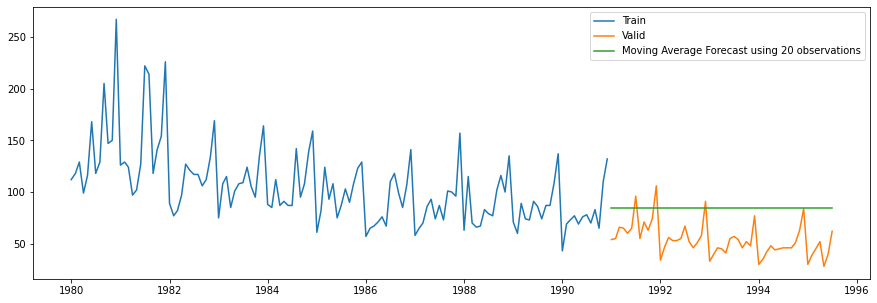

In [ ]:
#Moving Average
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Rose'].rolling(20).mean().iloc[-1] # average of last 20 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(Train['Rose'], label='Train') 
plt.plot(valid['Rose'], label='Valid') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 

In [ ]:
rms_ma_20 = sqrt(mean_squared_error(valid.Rose, y_hat_avg.moving_avg_forecast)) 
print(rms_ma_20)

34.395411295430364


**5.3 Simple Exponential Smoothing**

Simple Exponential Smoothing In this technique, we assign larger weights to more recent observations than to observations from the distant past. The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

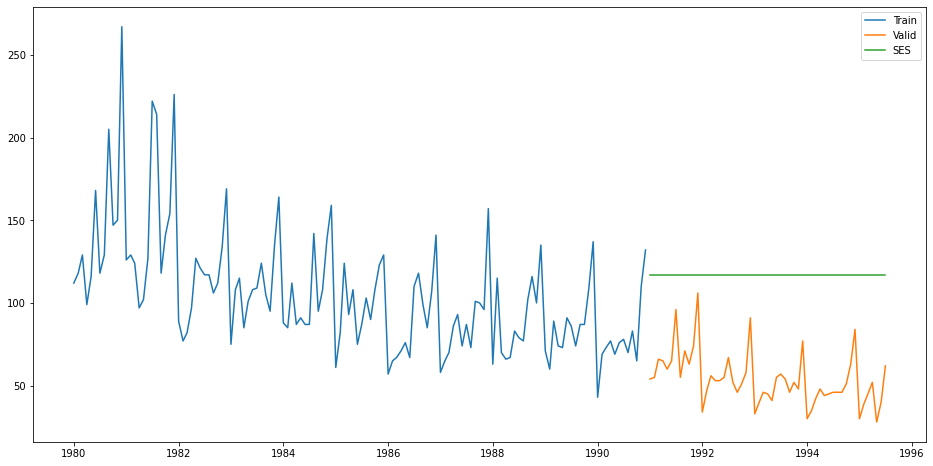

In [ ]:
# Simple Exponential Smoothing
y_hat_avg = valid.copy() 
fit2 = SimpleExpSmoothing(np.asarray(Train['Rose'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Rose'], label='Train') 
plt.plot(valid['Rose'], label='Valid') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()

In [ ]:
rms_sim = sqrt(mean_squared_error(valid.Rose, y_hat_avg.SES)) 
print(rms_sim)

64.95136996392496


**5.4 Holt’s Linear Trend Model**

It is an extension of simple exponential smoothing to allow forecasting of data with a trend. This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.

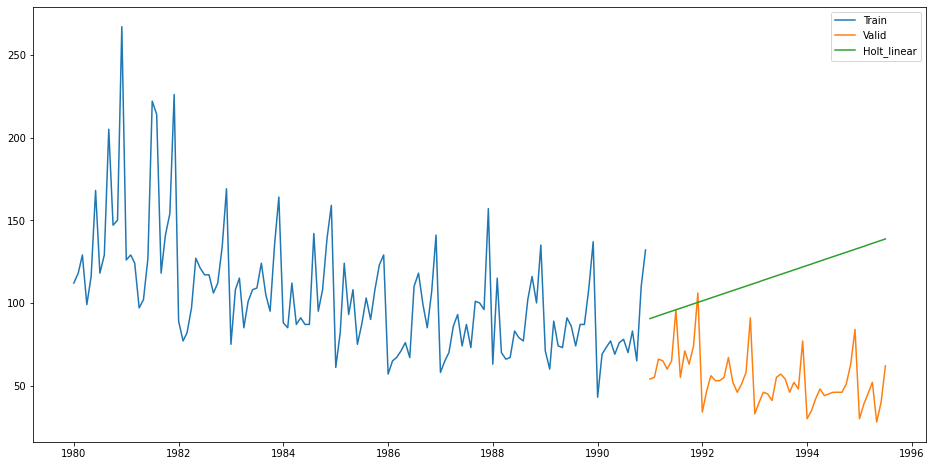

In [ ]:
# Holt’s Linear Trend Model
y_hat_avg = valid.copy() 
fit1 = Holt(np.asarray(Train['Rose'])).fit(smoothing_level = 0.2,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot(Train['Rose'], label='Train') 
plt.plot(valid['Rose'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [ ]:
rms_hot = sqrt(mean_squared_error(valid.Rose, y_hat_avg.Holt_linear)) 
print(rms_hot)

65.70876306909935


**6. Check Stationarity and Transformation** 

Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. So, the values are independent of time.

**6.1 How to test for stationarity?**

1. The stationarity of a series can be checked by looking at the plot of the series.
2. Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.
3. There are several quantitative methods we can use to determine if a given series is stationary or not. This can be done using statistical tests called Unit Root Tests. This test checks if a time series is non-stationary and possess a unit root.


**6.3 Augmented Dickey Fuller test** or (ADF Test) is the most commonly used test to detect stationarity. Here, we assume that the null hypothesis is the time series possesses a unit root and is non-stationary. Then, we collect evidence to support or reject the null hypothesis. So, if we find that the p-value in ADF test is less than the significance level (0.05), we reject the null hypothesis.

In [ ]:
#Augmented Dickey Fuller test
result = adfuller(Train.Rose.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
if result[1] <= 0.05:
    print ("Reject null hypothesis and data is stationary")
else:
    print ("Fail to reject H0 thereby data is non-stationary ") 

ADF Statistic: -2.164250
p-value: 0.219476
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
Fail to reject H0 thereby data is non-stationary 


**6.4 Kwiatkowski-Phillips-Schmidt-Shin test** - Another quite commonly used test for stationarity is the KPSS test. A very important point to note here is that the interpretation of KPSS is entirely opposite of the ADF test, and hence these tests cannot be used interchangeably. One needs to be very careful while interpreting these tests. KPSS test tests the below hypothesis.

Null Hypothesis, H0: The time series is stationary.
Alternative Hypothesis, H1: The time series is not stationary.


1. If the p-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, you reject H0 and conclude that the time series is not stationary.


2. If the p-value is greater than 0.05 or the absolute value of the test statistics is less than the critical value, you fail to reject H0 and conclude that the time series is stationary.

In [ ]:
#KPSS test
result = kpss(Train.Rose.values)

print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

if result[1] <= 0.05:
    print ("Reject null hypothesis and data is non-stationary")
else:
    print ("Fail to reject H0 thereby data is stationary ")


KPSS Test Statistic: 0.82
5% Critical Value: 0.46
p-value: 0.01
Reject null hypothesis and data is non-stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  -----
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  >>> res.bic_min_order


### **6.5 Transformation**

We can apply some sort of transformation to make the time-series stationary. These transformation may include:

1. Differencing the Series (once or more)
2. Take the log of the series
3. Take the nth root of the series
4. Combination of the above

The most commonly used and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary.

In [ ]:
Train['diff_o1'] = np.append(np.nan, np.diff(Train['Rose']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Augmented Dickey Fuller test to check stationarity for differenced dataset
result = adfuller(Train["diff_o1"].dropna().values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 
if result [1] <= 0.05:
    print ("Reject null hypothesis and data is stationary")
else:
    print ("Fail to reject H0 thereby data is non-stationary ") 

ADF Statistic: -6.592372
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
Reject null hypothesis and data is stationary


In [ ]:
#KPSS test
result = kpss(Train["diff_o1"].dropna().values)

print('KPSS Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[3]['5%'])
print('p-value: %.2f' % result[1])

if result[1] <= 0.05:
    print ("Reject null hypothesis and data is non-stationary")
else:
    print ("Fail to reject H0 thereby data is stationary ")


KPSS Test Statistic: 0.09
5% Critical Value: 0.46
p-value: 0.10
Fail to reject H0 thereby data is stationary 


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  -----
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  max_ar = int_like(max_ar, "max_ar")


Plot of transformed dataset.

Text(0.5, 1.0, 'Plot of 1 Differencing transformation')

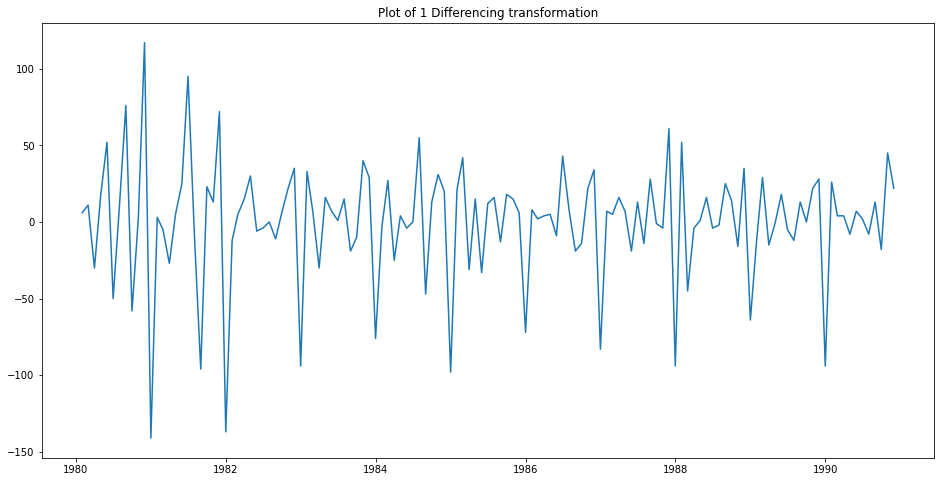

In [ ]:
plt.figure(figsize=(16,8)) 
plt.plot(Train['diff_o1'].dropna(), label='Train')
plt.title("Plot of 1 Differencing transformation")

**7. Autocorrelation and Partial Autocorrelation Functions**

**Autocorrelation** is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

**Partial Autocorrelation** also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

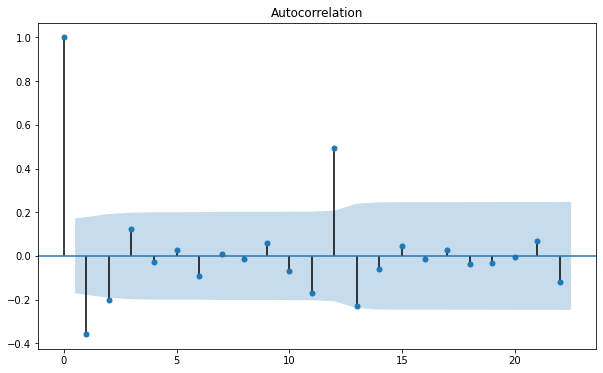

In [ ]:
plt.rcParams['figure.figsize'] = (10,6)
x=plot_acf(Train['diff_o1'].dropna())

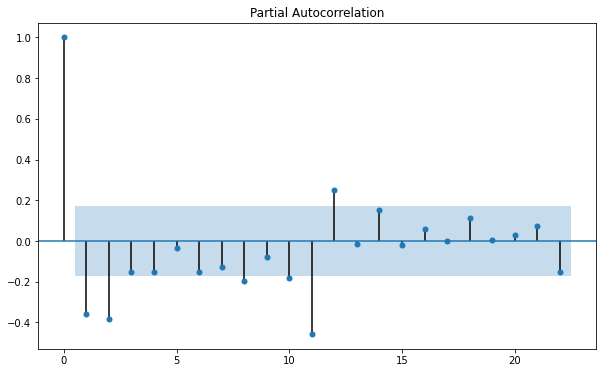

In [ ]:
plt.rcParams['figure.figsize'] = (10,6)
x=plot_pacf(Train['diff_o1'].dropna())

**Identifying the number of AR and MA terms**

1. p is equal to the first lag where the PACF value is above the significance level. p can be upto 1.

2. q is equal to the first lag where the ACF value is above the significance level. q can be 1.

**Identifying the seasonal part of the model:**

1. S is equal to the ACF lag with the highest value (typically at a high lag). Here S is on 12

2. D=0, since the seasonal pattern is not stable over time we set D = 0.

Rule of thumb: d+D≤2

3. P≥1, the ACF is positive at lag S, else P=0. It is P=1

4. Q≥1, the ACF is negative at lag S, else Q=0, it is Q = 0

### **8. Automate Arima/Sarima model**

Why am I using auto arima?

There are different combinations to be tried and compare the results. Auto-arima makes that very easy. since dataset involves seasonality, Sarima would to be better choice to contour seasonal pattern.

Three models are built :

1. Auto Sarima model using pmdarima package
2. Self Auto Sarima model 
3. Sarima model based on ACF and PACF cut-off 

**8.1 Auto Sarima model using pmdarima package**

In [ ]:
#building model on non-stationary dataset with starting value of d = 1, so that it become stationay
stepwise_model = auto_arima( Train['Rose'], start_p=0, start_q=0,
                           max_p=3, max_q=3, m=12,
                           start_P=0,max_P=3, seasonal=True,
                           d=1, D=0, max_d = 2, max_D=2,trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1307.486, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1335.153, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1275.846, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1333.155, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1319.349, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1258.918, Time=0.56 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1252.954, Time=1.27 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1251.047, Time=0.50 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1293.983, Time=0.19 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1252.983, Time=1.32 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1280.782, Time=0.69 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer


                                 Statespace Model Results                                 
Dep. Variable:                               Rose   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 0, 1, 12)   Log Likelihood                -594.281
Date:                            Fri, 21 May 2021   AIC                           1200.562
Time:                                    19:23:01   BIC                           1217.813
Sample:                                01-01-1980   HQIC                          1207.572
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5364      0.165     -3.242      0.001      -0.861      -0.212
ma.L1         -0.1584      0.146   

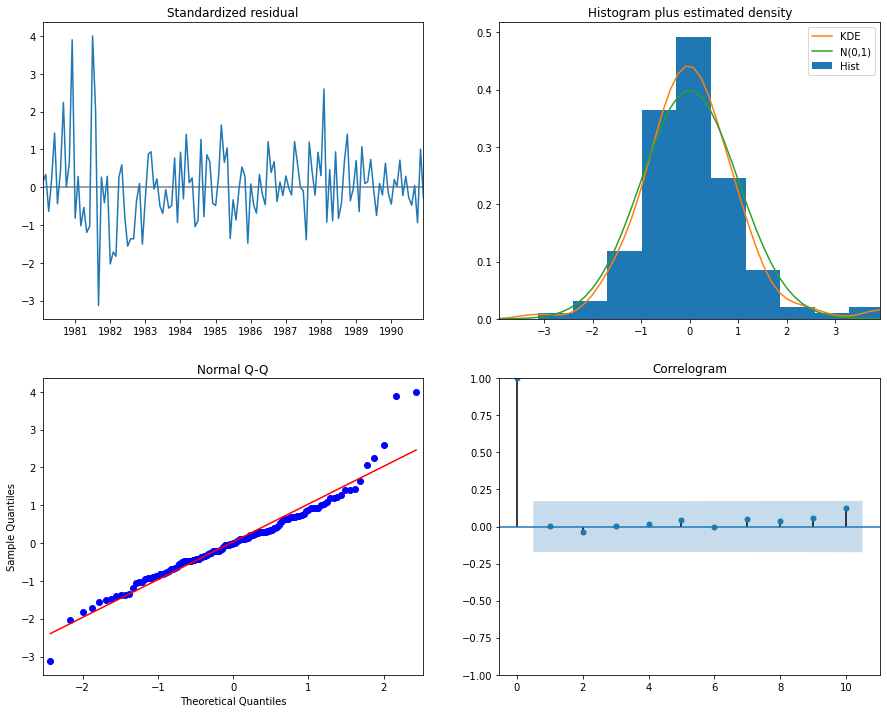

In [ ]:
# Applying Seasonal SARIMA model to forcast the data 
mod = sms.tsa.SARIMAX(Train['Rose'], order=(1,1,2), seasonal_order=(1, 0, 1, 12))  #also play with "trend" argument
result_1 = mod.fit()
print(result_1.summary())

result_1.plot_diagnostics(figsize=(15,12))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


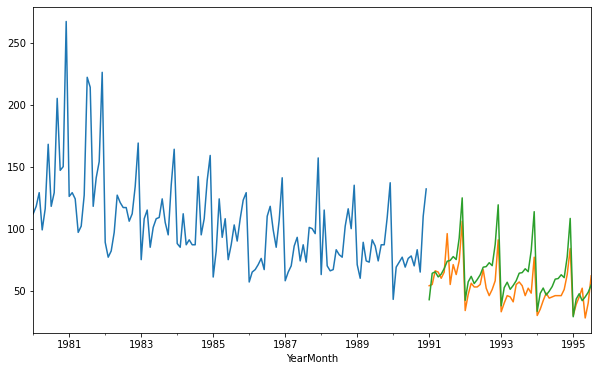

In [ ]:
valid["pred_1"] = result_1.forecast(len(valid))
Train['Rose'].plot()
valid["Rose"].plot()
valid["pred_1"].plot()

In [ ]:
rms_auto = sqrt(mean_squared_error(valid.Rose, valid.pred_1))
rms_auto

14.543192055787834

**8.2 Self Auto Sarima model**

In [ ]:
import itertools
#set parameter range
p = range(0,3)
q = range(0,3)
d = range(1,2)
s = range(6,12)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
Aic = []
ord = []
sea_ord = []
# SARIMA model pipeline
#building model on non-stationary dataset with starting value of d = 1, so that it become stationay
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sms.tsa.statespace.SARIMAX(Train['Rose'],
                                    order=param,
                                    seasonal_order=param_seasonal)
            result_2 = mod.fit(disp=-1)
            Aic.append(result_2.aic)
            ord.append(param)
            sea_ord.append(param_seasonal)
        except:
            continue

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer
/usr/local/lib/python3.7/dist-packages/stats

In [ ]:
Auto=pd.DataFrame.from_dict({"order":ord,"seasonal":sea_ord,"AIC":Aic})
dd = pd.DataFrame(Auto.sort_values(by = ['AIC'],ascending = True)).head()
dd

,order,seasonal,AIC
407,"(2, 1, 1)","(1, 1, 2, 6)",1155.557266
245,"(1, 1, 1)","(1, 1, 2, 6)",1157.186682
137,"(0, 1, 2)","(1, 1, 2, 6)",1158.068814
460,"(2, 1, 2)","(1, 1, 2, 6)",1158.178440
155,"(0, 1, 2)","(2, 1, 2, 6)",1159.837175


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


                                 Statespace Model Results                                
Dep. Variable:                              Rose   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, 2, 6)   Log Likelihood                -570.779
Date:                           Fri, 21 May 2021   AIC                           1155.557
Time:                                   19:32:17   BIC                           1175.355
Sample:                               01-01-1980   HQIC                          1163.600
                                    - 12-01-1990                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1546      0.086      1.788      0.074      -0.015       0.324
ar.L2         -0.1870      0.087     -2.147

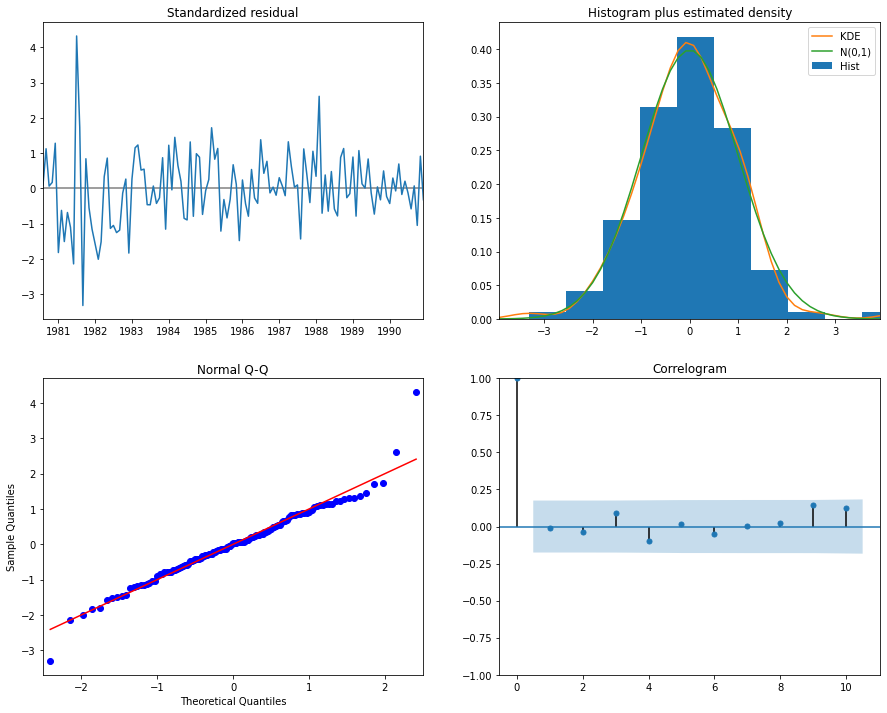

In [ ]:
# Applying Seasonal ARIMA model to forcast the data 
mod = sms.tsa.SARIMAX(Train['Rose'], order=(2, 1, 1), seasonal_order=(1, 1, 2, 6))  #also play with "trend" argument
result_2 = mod.fit()
print(result_2.summary())

result_2.plot_diagnostics(figsize=(15,12))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


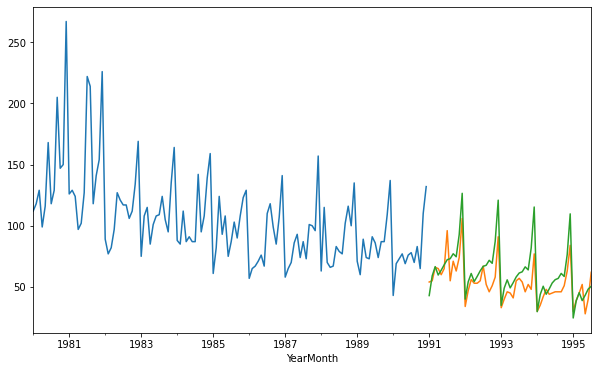

In [ ]:
valid["pred_2"] = result_2.forecast(len(valid))
Train['Rose'].plot()
valid["Rose"].plot()
valid["pred_2"].plot()

In [ ]:
rms_auto_fun = sqrt(mean_squared_error(valid.Rose, valid.pred_2))
rms_auto_fun

14.195272488616514

**8.3 Sarima based on ACF and PACF cutoff**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  # - Attemtping to index with a type that cannot be cast to integer


                                 Statespace Model Results                                 
Dep. Variable:                               Rose   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 12)   Log Likelihood                -610.410
Date:                            Fri, 21 May 2021   AIC                           1228.819
Time:                                    19:32:19   BIC                           1240.320
Sample:                                01-01-1980   HQIC                          1233.493
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1941      0.083      2.325      0.020       0.030       0.358
ma.L1         -0.9491      0.040   

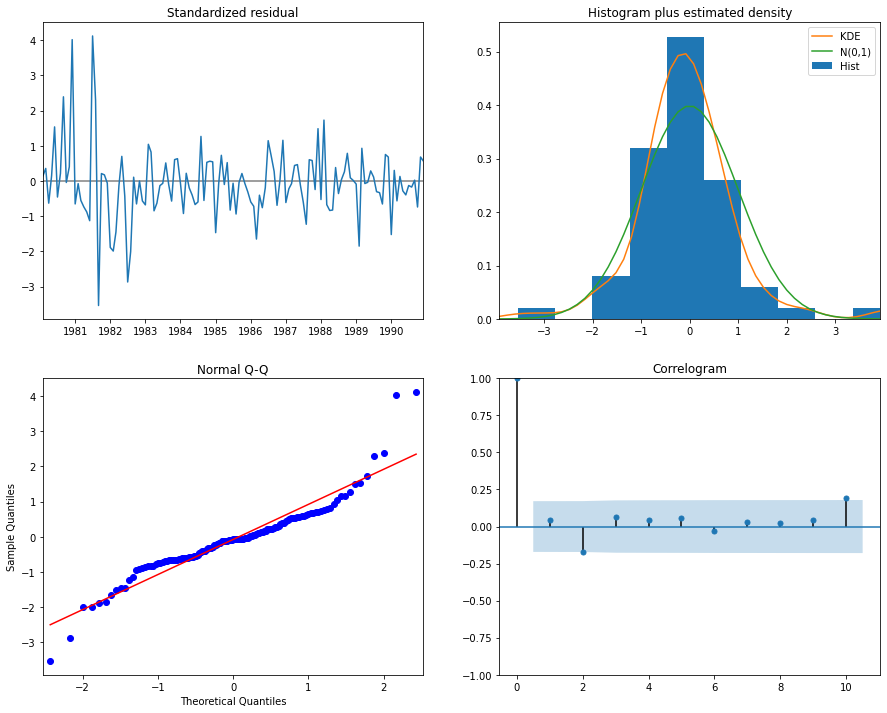

In [ ]:
# Applying Seasonal ARIMA model to forcast the data 
mod = sms.tsa.SARIMAX(Train["Rose"], order=(1,1,1), seasonal_order=(1,0,0,12))  #also play with "trend" argument
result_3 = mod.fit()
print(result_3.summary())

result_3.plot_diagnostics(figsize=(15,12))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


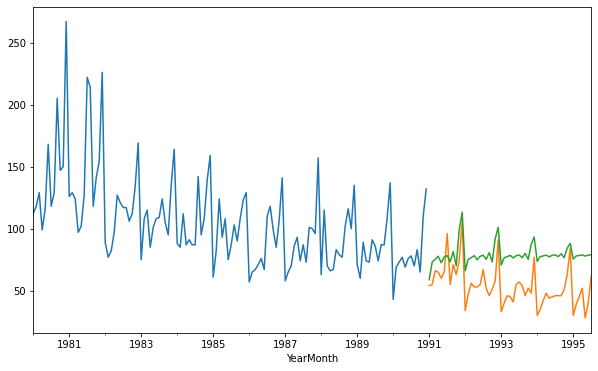

In [ ]:
valid["pred_3"] = result_3.forecast(len(valid))
Train['Rose'].plot()
valid["Rose"].plot()
valid["pred_3"].plot()


In [ ]:
rms_cutoff = sqrt(mean_squared_error(valid.Rose, valid.pred_3))
rms_cutoff

28.03648909515356

### **9. Prediction and Conclusion**

Based on the model-rmse values,the most optimum model is considered and predict 12 months into the future with appropriate confidence intervals/bands.

In [ ]:
RMSE = [rms_naive,rms_sim,rms_ma_10,rms_ma_20,rms_hot,rms_auto,rms_auto_fun,rms_cutoff]
Model = ["Naive_method","Simple_Exponential","Moving_Average_10rolling","Moving_Average_20_rolling","Hot_Linear","Auto_Sarima_PD","Auto_Sarima_fun","Sarima_cutoff"]
model_summary = pd.DataFrame({"Models":Model,"RMSE":RMSE})

In [ ]:
model_summary

,Models,RMSE
0,Naive_method,79.699093
1,Simple_Exponential,64.951370
2,Moving_Average_10rolling,33.377224
3,Moving_Average_20_rolling,34.395411
4,Hot_Linear,65.708763
5,Auto_Sarima_PD,14.543192
6,Auto_Sarima_fun,14.195272
7,Sarima_cutoff,28.036489


In [ ]:
prediction = result_2.get_forecast(len(valid)+12)
prediction = prediction.summary_frame(alpha=0.05)[len(valid):]
prediction

Rose,mean,mean_se,mean_ci_lower,mean_ci_upper
1995-08-01,51.594653,35.845576,-18.661385,121.850692
1995-09-01,55.676824,36.103767,-15.085259,126.438906
1995-10-01,53.154684,36.367039,-18.123403,124.432771
1995-11-01,70.931227,36.633053,-0.868237,142.730691
1995-12-01,104.120212,36.898536,31.800411,176.440014
1996-01-01,19.465792,37.949253,-54.913378,93.844961
1996-02-01,33.338668,38.354886,-41.835528,108.512865
1996-03-01,40.120824,38.586902,-35.508115,115.749763
1996-04-01,33.616848,38.864046,-42.555282,109.788978
1996-05-01,38.091971,39.177613,-38.694740,114.878682


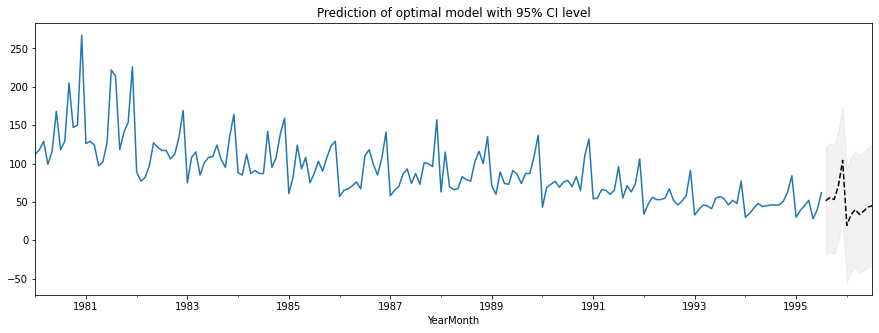

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
rose["Rose"].plot(ax=ax)

# Construct the forecasts
plt.title("Prediction of optimal model with 95% CI level")
prediction['mean'].plot(ax=ax, style='k--')
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.05);


**Conclusion:**
From the data analysis, we can suggest below suggestions to the wine makers:

1. Wine maker should more focus on first six months of years to increase company sales.

2. As model suggest, In next 12 months, December and November will be peak time for the sales and then onward it decrease.

3. Apart from this attributes, if trend changes in future then this model won't be sufficient to capture the behavior of dataset.